# How to build RNNs and LSTMs from scratch
# (Note: Template updated. This file implements LSTMs ONLY)

Originally developed by me (Nicklas Hansen), Peter Christensen and Alexander Johansen as educational material for the graduate deep learning course at the Technical University of Denmark (DTU). You can access the full course material [here](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch).
____

In this lab we will introduce different ways of learning from sequential data.
As an example, we will train a neural network to do language modelling, i.e. predict the next token in a sentence. In the context of natural language processing a token could be a character or a word, but mind you that the concepts introduced here apply to all kinds of sequential data, such as e.g. protein sequences, weather measurements, audio signals or monetary transaction history, just to name a few.

To really get a grasp of what is going on inside the recurrent neural networks that we are about to teach you, we will carry out a substantial part of this exercise in numpy rather than PyTorch. Once you get a hold of it, we will proceed to the PyTorch implementation.

In this notebook we will show you:
* How to represent categorical variables in networks
* How to build a recurrent neural network (RNN) from scratch
* How to build a LSTM network from scratch
* How to build a LSTM network in PyTorch

## Representing tokens or text

In previous labs we mainly considered data $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings. If you want to learn more about tokens, encodings and embeddings than what is covered in this exercise, we highly recommend [this lecture](https://www.youtube.com/watch?v=kEMJRjEdNzM&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

### One-hot encoding over vocabulary

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [1]:
# import numpy as np

# # Set seed such that we always get the same dataset
# np.random.seed(42)

# def generate_dataset(num_sequences=100):
#     """
#     Generates a number of sequences as our dataset.
    
#     Args:
#      `num_sequences`: the number of sequences to be generated.
     
#     Returns a list of sequences.
#     """
#     samples = []
    
#     for _ in range(num_sequences): 
#         num_tokens = np.random.randint(1, 10)
#         sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
#         samples.append(sample)
        
#     return samples


# sequences = generate_dataset()

# print('A single sample from the generated dataset:')
# print(sequences[0])

## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [2]:
# from collections import defaultdict

# def sequences_to_dicts(sequences):
#     """
#     Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
#     """
#     # A bit of Python-magic to flatten a nested list
#     flatten = lambda l: [item for sublist in l for item in sublist]
    
#     # Flatten the dataset
#     all_words = flatten(sequences)
    
#     # Count number of word occurences
#     word_count = defaultdict(int)
#     for word in flatten(sequences):
#         word_count[word] += 1

#     # Sort by frequency
#     word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

#     # Create a list of all unique words
#     unique_words = [item[0] for item in word_count]
    
#     # Add UNK token to list of words
#     unique_words.append('UNK')

#     # Count number of sequences and number of unique words
#     num_sentences, vocab_size = len(sequences), len(unique_words)

#     # Create dictionaries so that we can go from word to index and back
#     # If a word is not in our vocabulary, we assign it to token 'UNK'
#     word_to_idx = defaultdict(lambda: num_words)
#     idx_to_word = defaultdict(lambda: 'UNK')

#     # Fill dictionaries
#     for idx, word in enumerate(unique_words):
#         # YOUR CODE HERE!
#         word_to_idx[word] = idx
#         idx_to_word[idx] = word

#     return word_to_idx, idx_to_word, num_sentences, vocab_size


# word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

# print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
# print('The index of \'b\' is', word_to_idx['b'])
# print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

## Exercise:

Complete the `sequences_to_dicts` function above. You will need to fill the `word_to_idx` and `idx_to_word` dictionaries so that we can go back and forth between the two representations.

## Partitioning the dataset

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training, validation and test sets. 80%, 10% and 10% is a common distribution, but mind you that this largely depends on the size of the dataset. Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.

We can use PyTorch's `Dataset` class to build a simple dataset where we can easily retrieve (inputs, targets) pairs for each of our sequences.

In [3]:
# from torch.utils import data

# class Dataset(data.Dataset):
#     def __init__(self, inputs, targets):
#         self.inputs = inputs
#         self.targets = targets

#     def __len__(self):
#         # Return the size of the dataset
#         return len(self.targets)

#     def __getitem__(self, index):
#         # Retrieve inputs and targets at the given index
#         X = self.inputs[index]
#         y = self.targets[index]

#         return X, y

    
# def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
#     # Define partition sizes
#     num_train = int(len(sequences)*p_train)
#     num_val = int(len(sequences)*p_val)
#     num_test = int(len(sequences)*p_test)

#     # Split sequences into partitions
#     sequences_train = sequences[:num_train]
#     sequences_val = sequences[num_train:num_train+num_val]
#     sequences_test = sequences[-num_test:]

#     def get_inputs_targets_from_sequences(sequences):
#         # Define empty lists
#         inputs, targets = [], []
        
#         # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
#         # but targets are shifted right by one so that we can predict the next word
#         for sequence in sequences:
#             inputs.append(sequence[:-1])
#             targets.append(sequence[1:])
            
#         return inputs, targets

#     # Get inputs and targets for each partition
#     inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
#     inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
#     inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

#     # Create datasets
#     training_set = dataset_class(inputs_train, targets_train)
#     validation_set = dataset_class(inputs_val, targets_val)
#     test_set = dataset_class(inputs_test, targets_test)

#     return training_set, validation_set, test_set
    

# training_set, validation_set, test_set = create_datasets(sequences, Dataset)

# print(f'We have {len(training_set)} samples in the training set.')
# print(f'We have {len(validation_set)} samples in the validation set.')
# print(f'We have {len(test_set)} samples in the test set.')

When working with more complex data than what we use in this exercise, creating a PyTorch `DataLoader` on top of the dataset can be beneficial. A data loader is basically a fancy generator/iterator that we can use to abstract away all of the data handling and pre-processing + it's super useful for processing batches of data as well! Data loaders will come in handy later when you start to work on your projects, so be sure to check them out!

For more information on how to use datasets and data loaders in PyTorch, [consult the official guide](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [4]:
# def one_hot_encode(idx, vocab_size):
#     """
#     One-hot encodes a single word given its index and the size of the vocabulary.
    
#     Args:
#      `idx`: the index of the given word
#      `vocab_size`: the size of the vocabulary
    
#     Returns a 1-D numpy array of length `vocab_size`.
#     """
#     # Initialize the encoded array
#     one_hot = np.zeros(vocab_size)
    
#     # Set the appropriate element to one
#     one_hot[idx] = 1.0

#     return one_hot


# def one_hot_encode_sequence(sequence, vocab_size):
#     """
#     One-hot encodes a sequence of words given a fixed vocabulary size.
    
#     Args:
#      `sentence`: a list of words to encode
#      `vocab_size`: the size of the vocabulary
     
#     Returns a 3-D numpy array of shape (num words, vocab size, 1).
#     """
#     # Encode each word in the sentence
#     encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

#     # Reshape encoding s.t. it has shape (num words, vocab size, 1)
#     encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
#     return encoding


# test_word = one_hot_encode(word_to_idx['a'], vocab_size)
# print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

# test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
# print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Great! Now that we have our one-hot encodings in place, we can move on to the RNNs!

# Introduction to Recurrent Neural Networks (RNN)

Reading material: [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and (optionally) [this lecture](https://www.youtube.com/watch?v=iWea12EAu6U&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

___

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$

## Implementing a RNN

We will implement the forward pass, backward pass, optimization and training loop for a RNN in numpy so that you can get familiar with the recurrent nature of RNNs. Later, we will go back to PyTorch and appreciate how convenient the implementation becomes.

Let's define the necessary model parameters. Recall that an $n \times m$ weight matrix maps $\mathbb{R}^{m} \rightarrow \mathbb{R}^{n}$.

In [5]:
# hidden_size = 50 # Number of dimensions in the hidden state
# vocab_size  = len(word_to_idx) # Size of the vocabulary used

# def init_orthogonal(param):
#     """
#     Initializes weight parameters orthogonally.
    
#     Refer to this paper for an explanation of this initialization:
#     https://arxiv.org/abs/1312.6120
#     """
#     if param.ndim < 2:
#         raise ValueError("Only parameters with 2 or more dimensions are supported.")

#     rows, cols = param.shape
    
#     new_param = np.random.randn(rows, cols)
    
#     if rows < cols:
#         new_param = new_param.T
    
#     # Compute QR factorization
#     q, r = np.linalg.qr(new_param)
    
#     # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
#     d = np.diag(r, 0)
#     ph = np.sign(d)
#     q *= ph

#     if rows < cols:
#         q = q.T
    
#     new_param = q
    
#     return new_param


# def init_rnn(hidden_size, vocab_size):
#     """
#     Initializes our recurrent neural network.
    
#     Args:
#      `hidden_size`: the dimensions of the hidden state
#      `vocab_size`: the dimensions of our vocabulary
#     """
#     # Weight matrix (input to hidden state)
#     # YOUR CODE HERE!
#     U = np.zeros((hidden_size, vocab_size))

#     # Weight matrix (recurrent computation)
#     # YOUR CODE HERE!
#     V = np.zeros((hidden_size, hidden_size))

#     # Weight matrix (hidden state to output)
#     # YOUR CODE HERE!
#     W = np.zeros((vocab_size, hidden_size))

#     # Bias (hidden state)
#     # YOUR CODE HERE!
#     b_hidden = np.zeros((hidden_size, 1))

#     # Bias (output)
#     # YOUR CODE HERE!
#     b_out = np.zeros((vocab_size, 1))
    
#     # Initialize weights
#     U = init_orthogonal(U)
#     V = init_orthogonal(V)
#     W = init_orthogonal(W)
    
#     # Return parameters as a tuple
#     return U, V, W, b_hidden, b_out


# params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

## Exercise:

Define the appropriate shape of the weights and biases in the `init_rnn` function.

You only have to worry about the weight and bias dimensions; you can leave the scaling as is. Refer to the equations and figure above if you're in doubt here.

### Function definitions

Below we have defined the `sigmoid`, `tanh` and `softmax` functions. You might need them in a bit!

#### Sigmoid activation

In [6]:
# def sigmoid(x, derivative=False):
#     """
#     Computes the element-wise sigmoid activation function for an array x.

#     Args:
#      `x`: the array where the function is applied
#      `derivative`: if set to True will return the derivative instead of the forward pass
#     """
#     x_safe = x + 1e-12
#     f = 1 / (1 + np.exp(-x_safe))
    
#     if derivative: # Return the derivative of the function evaluated at x
#         return f * (1 - f)
#     else: # Return the forward pass of the function at x
#         return f

#### Hyperbolic Tangent activation

In [7]:
# def tanh(x, derivative=False):
#     """
#     Computes the element-wise tanh activation function for an array x.

#     Args:
#      `x`: the array where the function is applied
#      `derivative`: if set to True will return the derivative instead of the forward pass
#     """
#     x_safe = x + 1e-12
#     f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
#     if derivative: # Return the derivative of the function evaluated at x
#         return 1-f**2
#     else: # Return the forward pass of the function at x
#         return f

#### Softmax

In [8]:
# def softmax(x, derivative=False):
#     """
#     Computes the softmax for an array x.
    
#     Args:
#      `x`: the array where the function is applied
#      `derivative`: if set to True will return the derivative instead of the forward pass
#     """
#     x_safe = x + 1e-12
#     f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
#     if derivative: # Return the derivative of the function evaluated at x
#         pass # We will not need this one
#     else: # Return the forward pass of the function at x
#         return f

### Implement the forward pass

Now that we have all the definitions in place, we can start to implement a forward pass.

In [9]:
# def forward_pass(inputs, hidden_state, params):
#     """
#     Computes the forward pass of a vanilla RNN.
    
#     Args:
#      `inputs`: sequence of inputs to be processed
#      `hidden_state`: an already initialized hidden state
#      `params`: the parameters of the RNN
#     """
#     # First we unpack our parameters
#     U, V, W, b_hidden, b_out = params
    
#     # Create a list to store outputs and hidden states
#     outputs, hidden_states = [], []
    
#     # For each element in input sequence
#     for t in range(len(inputs)):

#         # Compute new hidden state
#         # YOUR CODE HERE!
#         hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

#         # Compute output
#         # YOUR CODE HERE!
#         out = softmax(np.dot(W, hidden_state) + b_out)
        
#         # Save results and continue
#         outputs.append(out)
#         hidden_states.append(hidden_state.copy())
    
#     return outputs, hidden_states


# # Get first sequence in training set
# test_input_sequence, test_target_sequence = training_set[0]

# # One-hot encode input and target sequence
# test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
# test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

# # Initialize hidden state as zeros
# hidden_state = np.zeros((hidden_size, 1))

# # Now let's try out our new function
# outputs, hidden_states = forward_pass(test_input, hidden_state, params)

# print('Input sequence:')
# print(test_input_sequence)

# print('\nTarget sequence:')
# print(test_target_sequence)

# print('\nPredicted sequence:')
# print([idx_to_word[np.argmax(output)] for output in outputs])

## Exercise:

Implement the forward pass in the code above. Refer to the equations and the figure if you're in doubt.

### Implement the backward pass

In [10]:
# def clip_gradient_norm(grads, max_norm=0.25):
#     """
#     Clips gradients to have a maximum norm of `max_norm`.
#     This is to prevent the exploding gradients problem.
#     """ 
#     # Set the maximum of the norm to be of type float
#     max_norm = float(max_norm)
#     total_norm = 0
    
#     # Calculate the L2 norm squared for each gradient and add them to the total norm
#     for grad in grads:
#         grad_norm = np.sum(np.power(grad, 2))
#         total_norm += grad_norm
    
#     total_norm = np.sqrt(total_norm)
    
#     # Calculate clipping coeficient
#     clip_coef = max_norm / (total_norm + 1e-6)
    
#     # If the total norm is larger than the maximum allowable norm, then clip the gradient
#     if clip_coef < 1:
#         for grad in grads:
#             grad *= clip_coef
    
#     return grads


# def backward_pass(inputs, outputs, hidden_states, targets, params):
#     """
#     Computes the backward pass of a vanilla RNN.
    
#     Args:
#      `inputs`: sequence of inputs to be processed
#      `outputs`: sequence of outputs from the forward pass
#      `hidden_states`: sequence of hidden_states from the forward pass
#      `targets`: sequence of targets
#      `params`: the parameters of the RNN
#     """
#     # First we unpack our parameters
#     U, V, W, b_hidden, b_out = params
    
#     # Initialize gradients as zero
#     d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
#     d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
#     # Keep track of hidden state derivative and loss
#     d_h_next = np.zeros_like(hidden_states[0])
#     loss = 0
    
#     # For each element in output sequence
#     # NB: We iterate backwards s.t. t = N, N-1, ... 1, 0
#     for t in reversed(range(len(outputs))):

#         # Compute cross-entropy loss (as a scalar)
#         # YOUR CODE HERE!
#         loss += -np.mean(np.log(outputs[t]+1e-12) * targets[t])
        
#         # Backpropagate into output (derivative of cross-entropy)
#         # if you're confused about this step, see this link for an explanation:
#         # http://cs231n.github.io/neural-networks-case-study/#grad
#         # YOUR CODE HERE!
#         d_o = outputs[t].copy()
#         d_o[np.argmax(targets[t])] -= 1
        
#         # Backpropagate into W
#         # YOUR CODE HERE!
#         d_W += np.dot(d_o, hidden_states[t].T)
#         d_b_out += d_o
        
#         # Backpropagate into h
#         # YOUR CODE HERE!
#         d_h = np.dot(W.T, d_o) + d_h_next
        
#         # Backpropagate through non-linearity
#         d_f = tanh(hidden_states[t], derivative=True) * d_h
#         d_b_hidden += d_f
        
#         # Backpropagate into U
#         # YOUR CODE HERE!
#         d_U += np.dot(d_f, inputs[t].T)
        
#         # Backpropagate into V
#         # YOUR CODE HERE!
#         d_V += np.dot(d_f, hidden_states[t-1].T)
#         d_h_next = np.dot(V.T, d_f)
    
#     # Pack gradients
#     grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
#     # Clip gradients
#     grads = clip_gradient_norm(grads)
    
#     return loss, grads


# loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

# print('We get a loss of:')
# print(loss)

## Exercise:

Implement the missing code in the backward pass above. Refer to previous weeks for the definition of cross-entropy or follow [this link](http://cs231n.github.io/neural-networks-case-study/#grad) for a hint.

### Optimization

Now that we can do forward passes and compute gradients with backpropagation, we're ready to train our network. For that we will need an optimizer. A common and easy to implement optimization method is gradient descent, which has the update rule: $\theta_{n+1} = \theta_{n} - \eta \frac{\partial E}{\partial \theta_{n}}$, where $\eta$ is the learning rate and $E$ is our cost function. This is essentially what's going on behind the scenes when you run `optimizer.step()` in PyTorch using the stochastic gradient descent optimizer.

In [11]:
# def update_parameters(params, grads, lr=1e-3):
#     # Take a step
#     for param, grad in zip(params, grads):
#         param -= lr * grad
    
#     return params

### Training loop

We need to define a full training loop with a forward pass, backward pass, optimization step and validation. Training will take approximately 5 minutes, so you might want to read on while the notebook is running.

In [12]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# # Hyper-parameters
# num_epochs = 1000

# # Initialize a new network
# params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# # Initialize hidden state as zeros
# hidden_state = np.zeros((hidden_size, 1))

# # Track loss
# training_loss, validation_loss = [], []

# # For each epoch
# for i in range(num_epochs):
    
#     # Track loss
#     epoch_training_loss = 0
#     epoch_validation_loss = 0
    
#      # For each sentence in validation set
#     for inputs, targets in validation_set:
        
#         # One-hot encode input and target sequence
#         inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
#         targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
#         # Re-initialize hidden state
#         hidden_state = np.zeros_like(hidden_state)

#         # Forward pass
#         # YOUR CODE HERE!
#         outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

#         # Backward pass
#         # YOUR CODE HERE!
#         loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
#         # Update loss
#         epoch_validation_loss += loss
    
#     # For each sentence in training set
#     for inputs, targets in training_set:
        
#         # One-hot encode input and target sequence
#         inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
#         targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
#         # Re-initialize hidden state
#         hidden_state = np.zeros_like(hidden_state)

#         # Forward pass
#         # YOUR CODE HERE!
#         outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

#         # Backward pass
#         # YOUR CODE HERE!
#         loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
#         if np.isnan(loss):
#             raise ValueError('Gradients have vanished!')
        
#         # Update parameters
#         params = update_parameters(params, grads, lr=3e-4)
        
#         # Update loss
#         epoch_training_loss += loss
        
#     # Save loss for plot
#     training_loss.append(epoch_training_loss/len(training_set))
#     validation_loss.append(epoch_validation_loss/len(validation_set))

#     # Print loss every 100 epochs
#     if i % 100 == 0:
#         print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# # Get first sentence in test set
# inputs, targets = test_set[1]

# # One-hot encode input and target sequence
# inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
# targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# # Initialize hidden state as zeros
# hidden_state = np.zeros((hidden_size, 1))

# # Forward pass
# outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
# output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
# print('Input sentence:')
# print(inputs)

# print('\nTarget sequence:')
# print(targets)

# print('\nPredicted sequence:')
# print([idx_to_word[np.argmax(output)] for output in outputs])

# # Plot training and validation loss
# epoch = np.arange(len(training_loss))
# plt.figure()
# plt.plot(epoch, training_loss, 'r', label='Training loss',)
# plt.plot(epoch, validation_loss, 'b', label='Validation loss')
# plt.legend()
# plt.xlabel('Epoch'), plt.ylabel('NLL')
# plt.show()

## Exercise:

Complete the training loop above and run the training. You can leave the hyper-parameters and network size unchanged.

A correct implementation should yield a loss **below 1.0** after 2000 epochs. How well does it predict the sequence?

## Extrapolation

Now that we have trained a RNN model, it's time to put it to test. We will provide the network with a starting sentence and let it `freestyle` from there!

In [13]:
# def freestyle(params, sentence='', num_generate=4):
#     """
#     Takes in a sentence as a string and outputs a sequence
#     based on the predictions of the RNN.
    
#     Args:
#      `params`: the parameters of the network
#      `sentence`: string with whitespace-separated tokens
#      `num_generate`: the number of tokens to generate
#     """
#     sentence = sentence.split(' ')
    
#     sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    
#     # Initialize hidden state as zeros
#     hidden_state = np.zeros((hidden_size, 1))

#     # Generate hidden state for sentence
#     outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
    
#     # Output sentence
#     output_sentence = sentence
    
#     # Append first prediction
#     word = idx_to_word[np.argmax(outputs[-1])]    
#     output_sentence.append(word)
    
#     # Forward pass
#     for i in range(num_generate):

#         # Get the latest prediction and latest hidden state
#         output = outputs[-1]
#         hidden_state = hidden_states[-1]
    
#         # Reshape our output to match the input shape of our forward pass
#         output = output.reshape(1, output.shape[0], output.shape[1])
    
#         # Forward pass
#         outputs, hidden_states = forward_pass(output, hidden_state, params)
        
#         # Compute the index the most likely word and look up the corresponding word
#         word = idx_to_word[np.argmax(outputs)]
        
#         output_sentence.append(word)
        
#     return output_sentence
    
# # Perform freestyle
# print('Example:')
# print(freestyle(params, sentence='a a a a a b'))

## Exercise:

What did you observe while building and training the model? How well does it freestyle? How many epochs are (roughly) needed for learning to make good predictions?

## Exercise (optional):

Alter the forward pass, backward pass and training loop to handle batches of inputs. You will see a great performance increase!

# Introduction to the Long Short-Term Memory (LSTM) Cell


Reading material: [Christopher Olah's walk-through](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

___


A vanilla RNN suffers from [the vanishing gradients problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem) which gives challenges in saving memory over longer sequences. To combat these issues the gated hidden units were created. The two most prominent gated hidden units are the Long Short-Term Memory (LSTM) cell and the Gated Recurrent Unit (GRU), both of which have shown increased performance in saving and reusing memory in later timesteps. In this exercise, we will focus on LSTM but you would easily be able to go ahead and implement the GRU as well based on the principles that you learn here.

Below is a figure of the LSTM cell:

![lstm](https://i.imgur.com/3VkmUCe.png)
Source: https://arxiv.org/abs/1412.7828


The LSTM cell contains three gates, input, forget, output gates and a memory cell.
The output of the LSTM unit is computed with the following functions, where $\sigma = \mathrm{softmax}$.
We have input gate $i$, forget gate $f$, and output gate $o$ defines as

- $i = \sigma ( W^i [h_{t-1}, x_t])$  (i - input)

- $f = \sigma ( W^f [h_{t-1},x_t])$   (f - forget)

- $o = \sigma ( W^o [h_{t-1},x_t])$   (o - output)

where $W^i, W^f, W^o$ are weight matrices applied to a concatenated $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)  for each respective gate.

$h_{t-1}$, from the previous time step along with the current input $x_t$ are used to compute the a candidate $g$

- $g = \mathrm{tanh}( W^g [h_{t-1}, x_t])$

The value of the cell's memory, $c_t$, is updated as

- $c_t = c_{t-1} \circ f + g \circ i$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication.

The output, $h_t$, is computed as

- $h_t = \mathrm{tanh}(c_t) \circ o$

and it is used for both the timestep's output and the next timestep, whereas $c_t$ is exclusively sent to the next timestep.
This makes $c_t$ a memory feature, and is not used directly to compute the output of the timestep.

## Initialiation of a LSTM network

Similarly to before we will implement the forward pass, backward pass, optimization and training loop, now for an LSTM in numpy. Later, we will go back to PyTorch and appreciate how convenient the implementation becomes.

In [14]:
# Load all necessary libraries and functions
import numpy as np
from collections import defaultdict
from torch.utils import data
np.random.seed(42)
#-------------------------------------------------------------------------
def generate_dataset(num_sequences=100):
    """
    Generates a number of sequences as our dataset.
    Args:
     `num_sequences`: the number of sequences to be generated.
    Returns a list of sequences.
    """

    samples = []
    
    for _ in range(num_sequences):  
        num_tokens = np.random.randint(1, 10) # pick a number of tokens to be generated
        # generate an equal number of 'a's and 'b's, followed by an 'EOS' token, e.g.: ['a', 'a', 'a', 'b', 'b', 'b', 'EOS']
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    Args:
        `sequences`: a list of sequences
    """
    
    # A bit of Python-magic to flatten a nested list 'list_param'
    flatten = lambda list_param: [
        item 
        for sublist in list_param #loop over the elements of list_param creating a sublist
        for item in sublist #loop over the elements of sublist creating an item
    ]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int) #defaultdict is a dictionary that returns a default value if the key is not found, here the default value is 0
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency in descending order
    # word_count.items() returns a list of (word, count) pairs. 'l' is a tuple (word, count). Then we sort the list of tuples by the count '-l[1]'
    # this would be better as: word_count_desc = sorted(list(word_count.items()), key=lambda tuple_item: tuple_item[1], reverse=True)
    word_count_desc = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count_desc]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    # word_to_idx = defaultdict(lambda: num_words) #probably should be vocab_size
    word_to_idx = defaultdict(lambda: vocab_size)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs # x
        self.targets = targets # y

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        x = self.inputs[index]
        y = self.targets[index]

        return x, y
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def get_inputs_targets_from_sequences(sequences):
    # Define empty lists
    inputs, targets = [], []
    
    # Append inputs and targets such that both lists contain L-1 words of a sentence of length L
    # but targets are shifted right by one so that we can predict the next word
    # example: 'The quick brown fox jumps'
    #    Inputs:  ["The", "quick", "brown", "fox"]
    #    Targets: ["quick", "brown", "fox", "jumps"]
    # The idea is to predict the next word based on the input words, so the model learns to predict 
    # "quick" given "The", "brown" given "quick", and so on.
    for sequence in sequences:
        inputs.append(sequence[:-1]) # take everything except the last word -> ["The", "quick", "brown", "fox"]
        targets.append(sequence[1:]) # take everything except the first word -> ["quick", "brown", "fox", "jumps"]
        
    return inputs, targets
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int( len(sequences)*p_train ) #typically 80% of the data
    num_validation = int( len(sequences)*p_val )     #typically 10% of the data
    num_test = int( len(sequences)*p_test )   #typically 10% of the data

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_validation = sequences[num_train:num_train+num_validation]
    sequences_test = sequences[-num_test:]

    # In the next step we split this into inputs and targets. So far we have sequences for: 
    #   Training, Validation, and Test. After that we will have:
    #   Training (Inputs, Targets), Validation (Inputs, Targets), and Test (Inputs, Targets)

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_validation, targets_validation = get_inputs_targets_from_sequences(sequences_validation)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_validation, targets_validation)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------  
def init_orthogonal(param):
    """    
    Initializes weight parameters orthogonally. (Meaning orthogonal matrix)
       Refer to this paper for an explanation of this initialization:
       https://arxiv.org/abs/1312.6120
    """
    
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols) #randn -> sample(s) standard normal distribution in the shape of rows x cols
    
    if rows < cols:
        new_param = new_param.T #transpose the matrix, if 3x2 -> 2x3
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    # consider:
    # r = np.array([[0, 1, 2],
    #               [3, 4, 5],
    #               [6, 7, 8]])
    # np.diag(r, 0) -> [0 4 8]    np.diag(r, 1) -> [1 5]    np.diag(r, -1) -> [3 7]
    d = np.diag(r, 0)

    # np.sign(d): This function returns an array of the same shape as d, where each element is the sign of the corresponding element in d.
    #   If an element in d is positive, the corresponding element in ph will be 1.
    #   If an element in d is negative, the corresponding element in ph will be -1.
    #   If an element in d is zero, the corresponding element in ph will be 0.
    # Consider: d = np.array([4, -5, 0]) -> ph = np.sign(d) -> [1 -1 0]
    ph = np.sign(d)

    q *= ph # multiplies each column of q by each element in ph, ensuring that the orthogonal matrix q has the desired properties

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param
#-------------------------------------------------------------------------

In [15]:
#-------------------------------------------------------------------------
def init_lstm(hidden_layer_size, vocab_size, z_size):
    """
    Initializes our LSTM network.
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
     `z_size`: the dimensions of the concatenated input 
    """
    # print(f'z_size: {z_size}') # typically: 50 + 4 = 54
    #------------------
    # Standard init, weights with random and biases with zeros
    W_f = np.random.randn(hidden_layer_size, z_size) #weight matrix of the forget gate
    b_f = np.zeros((hidden_layer_size, 1)) #fotget gate bias
    #------
    W_i = np.random.randn(hidden_layer_size, z_size) #weight matrix of the input gate
    b_i = np.zeros((hidden_layer_size, 1)) #input gate bias
    #------
    # the candidate refers to the potential new values that could be added to the cell state
    W_g = np.random.randn(hidden_layer_size, z_size) #weight matrix of the candidate
    b_g = np.zeros((hidden_layer_size, 1)) #candidate bias
    #------
    W_o = np.random.randn(hidden_layer_size, z_size) #weight matrix of the output gate
    b_o = np.zeros((hidden_layer_size, 1)) #output bias
    #------
    W_v = np.random.randn(vocab_size, hidden_layer_size) #weight matrix relating the hidden-state to the output
    b_v = np.zeros((vocab_size, 1)) #bias relating the hidden-state to the output
    #------------------
    # Orthogonal init, for more details: https://arxiv.org/abs/1312.6120
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)
    #------------------

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v
#-------------------------------------------------------------------------

In [16]:
#-------------------------------------------------------------------------
def execute_part11_I():
    print('Part 11 - I')
    sequences = generate_dataset()
    print('A single sample from the generated dataset:')
    print(sequences[0])
    return {
        'sequences': sequences
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part11_II(sequences):
    print('Part 11 - II')
    word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)
    print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
    print('The index of \'b\' is', word_to_idx['b'])
    print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

    print(f'vocab_size: {vocab_size}')
    for i in range(vocab_size):
        print(f'{i}: {idx_to_word[i]}')      
    return {
        'word_to_idx': word_to_idx,
        'idx_to_word': idx_to_word,
        'num_sequences': num_sequences,
        'vocab_size': vocab_size
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part11_III(sequences):
    print('Part 11 - III')
    training_set, validation_set, test_set = create_datasets(sequences = sequences, dataset_class = Dataset)
    return {
        'training_set': training_set,
        'validation_set': validation_set,
        'test_set': test_set
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part11(hidden_layer_size = 50):
    print('PART 11')
    print('----------------')
    part11_I_result = execute_part11_I()
    print('----------------')
    part11_II_result = execute_part11_II(part11_I_result['sequences'])
    print('----------------')
    part11_III_result = execute_part11_III(part11_I_result['sequences'])
    print('----------------')
    
    vocab_size = part11_II_result['vocab_size']
    z_size = hidden_layer_size + vocab_size # typically: 50 + 4 = 54

    params = init_lstm(hidden_layer_size=hidden_layer_size, vocab_size=vocab_size, z_size=z_size)

    return {
        'sequences'     : part11_I_result['sequences'],
        'vocab_size'    : vocab_size,
        'word_to_idx'   : part11_II_result['word_to_idx'],
        'idx_to_word'   : part11_II_result['idx_to_word'],
        'num_sequences' : part11_II_result['num_sequences'],
        'hidden_layer_size': hidden_layer_size,
        'params'        : params,
        'training_set'  : part11_III_result['training_set'],
        'validation_set': part11_III_result['validation_set'],
        'test_set'      : part11_III_result['test_set']
    }
#-------------------------------------------------------------------------
part11_result = execute_part11()

PART 11
----------------
Part 11 - I
A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
----------------
Part 11 - II
We have 100 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'
vocab_size: 4
0: a
1: b
2: EOS
3: UNK
----------------
Part 11 - III
----------------


## Exercise:

Implement the initlizations in the code above. Refer to the equations and the figure if you're in doubt.

## Forward pass

As before we need to bring the equations into pieces of code. This is done in the following function:

In [17]:
#-------------------------------------------------------------------------
def sigmoid(x, derivative = False):
    """    
    Computes the element-wise sigmoid activation function for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12 # this is a low-low value
    f_x = 1 / (1 + np.exp(-x_safe))
    
    #sigmoid function: f(x) = 1 / (1 + e^(-x))
    #derivative of sigmoid: f'(x) = f(x) * (1 - f(x))
    if derivative: # Return the derivative of the function evaluated at x
        d_f_x = f_x * (1 - f_x)
        return d_f_x
    else: # Return the forward pass of the function at x
        return f_x
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def tanh(x, derivative = False):
    """
    Computes the element-wise tanh activation function for an array x.
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    #-----
    # tanh function: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))   ALSO: f(x) = sinh(x) / cosh(x)
    # derivative of tanh: f'(x) = 1 - f(x)^2                  OR f'(x) = 1 - tanh^2(x)

    x_safe = x + 1e-12 # this is a low-low value
    f_x = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        d_f_x = 1 - f_x**2
        return d_f_x
    else: # Return the forward pass of the function at x
        return f_x
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def softmax(x, derivative = False ):
    """
    Computes the softmax for an array x.
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass\
    """
    #-----
    # softmax function: f(x) = e^x / sum(e^x)
    # derivative of softmax: "The derivative of the softmax function is a bit more complicated because softmax depends on all the elements of the input vector x ."

    x_safe = x + 1e-12 # this is a low-low value
    f_x = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one (truth is the derivative of softmax is very hard)
    else: # Return the forward pass of the function at x
        return f_x
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------    
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
       
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """

    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------    
def one_hot_encode_sequence(sequence, vocab_size, word_to_idx):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
        
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """

    # Encode each word in the sentence. From each word in a sentence, we send the index of the word and vocab_size
    #  we expect to receive back the one-hot encoding of the word, something like [0,0,0,1,0,0,0,...]
    encoding = np.array(
            [   
                one_hot_encode(word_to_idx[word], vocab_size) 
                for word in sequence
            ]
        )

    # Reshape encoding to (len_num words, len_vocab size, 1)
    encoding = encoding.reshape( encoding.shape[0], encoding.shape[1], 1 )
    
    return encoding
#-------------------------------------------------------------------------

In [18]:
#-------------------------------------------------------------------------
def forward(inputs, hidden_state_prev, C_prev, params, hidden_layer_size):
    """
    Arguments:
    inputs -- your input data at timestep "t", numpy array of shape (n_x, m).
    hidden_state_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    C_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    params -- python list containing :
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Note: W_f and other weights have their size defined by z_size defined at init_lstm
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- lists of size m containing the computations in each forward pass
    outputs -- prediction at timestep "t", numpy array of shape (n_v, m)
    """
    # z_s will be a list of the concatenated input and hidden state
    # f_s will be a list of the forget gate computations
    # i_s will be a list of the input gate computations
    # g_s will be a list of the candidate computations
    # C_s will be a list of the cell state computations
    # o_s will be a list of the output gate computations
    # h_s will be a list of the hidden state computations
    # v_s will be a list of the logit computations

    assert hidden_state_prev.shape == (hidden_layer_size, 1)
    assert C_prev.shape == (hidden_layer_size, 1)
    #--------
    # First we unpack our parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = params
    
    # Save a list of computations for each of the components in the LSTM
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    #--------


    # Append the initial cell and hidden state to their respective lists
    h_s.append(hidden_state_prev) # 0's in the first execution
    C_s.append(C_prev) #0's in the first execution
    

    # inputs will be a list of one-hot encoded words, in our example most likely a sentence with 14 words, and the vocab size is 4,
    #  so the shape will be (14,4,1), and they will typically look like this: [[[1],[0],[0],[0]], [[0],[1],[0],[0]], ...]
    # and x will be [[1],[0],[0],[0]]
    for key, x in enumerate(inputs):
        # Concatenate input and hidden state
        z = np.row_stack((hidden_state_prev, x)) #this one will look like (54,1) and [[0],[1],[0],[0],...,[1],[0],[0],[0]] - where this last [1],[0],[0],[0] is x
        z_s.append(z) 

        #--------
        # Notes and refreshers: Dot product - Consider matrices A and B. The dot product of A and B requires thart number of columns in A to be
        #  equal to the number of rows in B. And the result will be the number of rows in A and the number of columns in B.
        #  For example: A shape (50,54) and B shape (54,1) will result in a matrix of shape (50,1)
        #                        R   C               R  C  -> A_cols = 54, B_rows = 54, A_rows = 50, B_cols = 1, result = (50,1)
        #--------
        # Notes on addition of 2 np.arrays: Considering the shape we are dealing with (50,1), adding 2 arrays the result is performed element-wise,
        #  for instance: [[1],[2],[3]] + [[4],[5],[6]] = [[5],[7],[9]]
        #--------

        # Calculate forget gate, W_f is the weights for the forget gate, tipycally in our example, 50 layers of 54 z's
        # W_f shape: (50, 54), z shape: (54, 1), b_f shape: (50, 1)
        temp_forget = np.dot(W_f, z) #dot product of weight of forget gate and concatenated input and hidden state
        temp_forget = temp_forget + b_f # apply bias
        forget = sigmoid(temp_forget) #apply activation function
        f_s.append(forget)
        #--------
        # Calculate input gate
        temp_input = np.dot(W_i, z) # dot product of weight of input gate and concatenated input and hidden state
        temp_input = temp_input + b_i # apply bias
        input = sigmoid(temp_input) # apply activation function
        i_s.append(input)
        #--------
        # Calculate candidate
        temp_candidate = np.dot(W_g, z) # dot product of weight of candidate and concatenated input and hidden state
        temp_candidate = temp_candidate + b_g # apply bias
        g_candidate = tanh(temp_candidate) # apply activation function
        g_s.append(g_candidate)
        #--------
        # Calculate memory state
        #   Now this is interesting because we say how much we should forget from the previous state (C_prev) and how much we should 
        #     add to the state (input * g_candidate), the forget or input values should range from 0 to 1, and we should expect something
        #     like this:  0.7 * C_prev + 0.99 * g_candidate, meaning: retain 70% of the previous state and add 99% of the candidate
        C_prev = forget * C_prev + input * g_candidate  # C_prev is passed as a parameter
        C_s.append(C_prev)
        #--------
        # Calculate output gate
        temp_output_gate = np.dot(W_o, z) # dot product of weight of output gate and concatenated input and hidden state
        temp_output_gate = temp_output_gate + b_o # apply bias
        output_gate = sigmoid(temp_output_gate) # apply activation function
        o_s.append(output_gate)
        #--------
        # Calculate hidden state
        hidden_state_prev = output_gate * tanh(C_prev)
        h_s.append(hidden_state_prev)
        #--------
        # Calculate logits
        #  "logits" refer to the raw, unnormalized scores that a model outputs before 
        #  applying an activation function like the softmax, as we can see below
        v_temp = np.dot(W_v, hidden_state_prev) # dot product of weights of the hidden state and the hidden state
        v = v_temp + b_v # apply bias
        v_s.append(v)
        #--------
        # Calculate softmax
        output_softmax = softmax(v)
        output_s.append(output_softmax)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s
#-------------------------------------------------------------------------

In [19]:
#-------------------------------------------------------------------------
def execute_part12(vocab_size, hidden_layer_size, params, idx_to_word, word_to_idx, test_set):
    print('PART 12')
    # Get first sentence in test set
    inputs, targets = test_set[1]

    # One-hot encode input and target sequence
    inputs_one_hot = one_hot_encode_sequence(sequence = inputs, vocab_size = vocab_size, word_to_idx=word_to_idx)
    targets_one_hot = one_hot_encode_sequence(sequence = targets, vocab_size = vocab_size, word_to_idx=word_to_idx)

    # Initialize hidden state as zeros
    h = np.zeros((hidden_layer_size, 1))
    c = np.zeros((hidden_layer_size, 1))

    #-----------
    # Forward pass
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(
        inputs              = inputs_one_hot, 
        hidden_state_prev   = h, 
        C_prev              = c, 
        params              = params, 
        hidden_layer_size   = hidden_layer_size
    )
    #-----------

    output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
    print('Input sentence:')
    print(inputs)

    print('\nTarget sequence:')
    print(targets)

    print('\nPredicted sequence:')
    predicted = [idx_to_word[np.argmax(output)] for output in outputs]
    print(predicted)
    print('This is supposed to be junk - just ignore it')

    return{
        'inpus'             : inputs,
        'targets'           : targets,
        'inputs_one_hot'    : inputs_one_hot,
        'targets_one_hot'   : targets_one_hot,
        'h'                 : h,
        'c'                 : c,
        'z_s'               : z_s,
        'f_s'               : f_s,
        'i_s'               : i_s,
        'g_s'               : g_s,
        'C_s'               : C_s,
        'o_s'               : o_s,
        'h_s'               : h_s,
        'v_s'               : v_s,
        'outputs': outputs
    }
#-------------------------------------------------------------------------

part12_result = execute_part12(
    vocab_size          = part11_result['vocab_size'],
    hidden_layer_size   = part11_result['hidden_layer_size'],
    params              = part11_result['params'],
    idx_to_word         = part11_result['idx_to_word'],
    word_to_idx         = part11_result['word_to_idx'],
    test_set            = part11_result['test_set']
)


PART 12
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'a', 'a', 'b', 'b', 'b', 'b', 'b']
This is supposed to be junk - just ignore it


## Exercise:

Complete the implementation of the LSTM forward pass above. Refer to the equations and figures further up if you're in doubt.

## Backward pass

Similar to the RNN in numpy we also need to specify a backward pass. Fortunately some of the TA's have a lot of free time to do that for you :-) 

In [20]:
#-------------------------------------------------------------------------
def clip_gradient_norm(grads, max_norm=0.25):
    {
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """
    # rememnber: grads = d_U, d_V, d_W, d_b_hidden, d_b_out  
    #   U - weight input to hidden state
    #   V - weight matrix recurrent computation
    #   W - weight matrix hidden state to output
    #   bias_hidden shape
    #   bias_out
    # print(f'grads[0] U shape: {grads[0].shape}')
    # print(f'grads[1] V shape: {grads[1].shape}')
    # print(f'grads[2] W shape: {grads[2].shape}')
    # print(f'grads[3] b_hidden shape: {grads[3].shape}')
    # print(f'grads[4] b_out shape: {grads[4].shape}')
    }


    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0

    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)

    # print(f'total_norm: {total_norm}') #from the example this should be around 28.2843
    # print(f'clip_coef: {clip_coef}') #from the example this would be around 0.008835
    
    #------------------
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            # print(f'----')
            # print(f'grad: {grad}')
            # print(f'new grad: {grad * clip_coef}')
            grad *= clip_coef  # !!! KEEP THIS CODE!!!! grad = grad * clip_coef IS NOT STABLE. Python bug

    #------------------
    
    return grads
#-------------------------------------------------------------------------

In [21]:
#-------------------------------------------------------------------------
def backward(z, f, i, g, C, o, h, v, hidden_layer_size, outputs, targets, params):
    """
    Arguments:
    z -- your concatenated input data  as a list of size m.
    f -- your forget gate computations as a list of size m.
    i -- your input gate computations as a list of size m.
    g -- your candidate computations as a list of size m.
    C -- your Cell states as a list of size m+1.
    o -- your output gate computations as a list of size m.
    h -- your Hidden state computations as a list of size m+1.
    v -- your logit computations as a list of size m.
    outputs -- your outputs as a list of size m.
    targets -- your targets as a list of size m.
    params -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    loss -- crossentropy loss for all elements in output
    grads -- lists of gradients of every element in p
    """

    # Unpack parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = params 

    #-----------------------------------
    # Initialize gradients as zero
    W_f_d = np.zeros_like(W_f) # weights of the forget gate (derivative)
    b_f_d = np.zeros_like(b_f) # bias of the forget gate (derivative)

    W_i_d = np.zeros_like(W_i) # weights of the input gate (derivative)
    b_i_d = np.zeros_like(b_i) # bias of the input gate (derivative)

    W_g_d = np.zeros_like(W_g) # weights of the candidate (derivative)
    b_g_d = np.zeros_like(b_g) # bias of the candidate (derivative)

    W_o_d = np.zeros_like(W_o) # weights of the output gate (derivative)
    b_o_d = np.zeros_like(b_o) # bias of the output gate (derivative)

    W_v_d = np.zeros_like(W_v) # weights relating the hidden-state to the output (derivative)
    b_v_d = np.zeros_like(b_v) # bias relating the hidden-state to the output (derivative)
    
    # Set the next cell and hidden state equal to zero
    dh_next = np.zeros_like(h[0]) # hidden state (derivative)
    dC_next = np.zeros_like(C[0]) # cell state (derivative)
    #-----------------------------------
    # Track loss
    loss = 0

        
    for t in reversed(range(len(outputs))): #outputs len: 14 (as our sentence has 14 words), so this will be a loop from 13 to 0
        

        # Compute cross-entropy loss
        {
        #  Remember we can have targets shape as (14, 4, 1) and outputs shape as (14, 4, 1), so what we do here
        #    is outputs[0]->(4,1) , targets[0]->(4,1)  
        #       
        # Formula: Loss += -(1/N) * SUM(i->n)[ y * log(y_hat + E) ] 
        #  note that 1/N*SUM(i->n) is the same as np.mean()
        }
        # Compute the cross entropy
        loss += -np.mean( np.log( outputs[t] + 1e-12 ) * targets[t] )

        #-----
        # Get the previous hidden cell state
        #  note C has a length of 15, as it starts with 0's added even before the first forward pass, and that makes sense since we are
        #    using 't-1', so se just pad this array with 0's for convenience and to demonstrate an initial memory state of 0's before the first input
        C_prev= C[t-1] 
        
        #-----
        # Compute the derivative of the relation of the hidden-state to the output gate
        dv = np.copy( outputs[t] )
        {
        # if you're confused about this step, see this link for an explanation:
        # http://cs231n.github.io/neural-networks-case-study/#grad
        #   Suppose outputs[t] is [0.1, 0.7, 0.2] and targets[t] is [0, 1, 0] (one-hot encoded)
        # The code would execute as follows:
        #     d_o = outputs[t].copy() results in d_o = [0.1, 0.7, 0.2].
        #     np.argmax(targets[t]) returns 1 (the index of the maximum value in targets[t]).
        #     d_o[1] -= 1 modifies d_o to [0.1, -0.3, 0.2].
        }        
        dv[np.argmax(targets[t])] -= 1
        #-----

        # Update the gradient of the relation of the hidden-state to the output gate
        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # Compute the derivative of the hidden state and output gate
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do
        
        # Update the gradients with respect to the output gate
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Compute the derivative of the cell state and candidate g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg
        
        # Update the gradients with respect to the candidate
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Compute the derivative of the input gate and update its gradients
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Compute the derivative of the forget gate and update its gradients
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Compute the derivative of the input and update the gradients of the previous hidden and cell state
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_layer_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Clip gradients
    grads = clip_gradient_norm(grads = grads)
    
    return loss, grads
#-------------------------------------------------------------------------

In [22]:
#-------------------------------------------------------------------------
def execute_part13(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, hidden_layer_size, outputs, targets_one_hot, params):
    print('PART 13')

    
    
    # Perform a backward pass
    loss, grads = backward(z = z_s, f = f_s, i = i_s, g = g_s, C = C_s, o = o_s, h = h_s, v = v_s, 
                           hidden_layer_size= hidden_layer_size, outputs = outputs, targets=targets_one_hot, params = params)

    print('We get a loss of:')
    print(loss)

    return {
        'loss': loss,
        'grads': grads
    }
#-------------------------------------------------------------------------
execute_part13(
    z_s                 = part12_result['z_s'],
    f_s                 = part12_result['f_s'],
    i_s                 = part12_result['i_s'],
    g_s                 = part12_result['g_s'],
    C_s                 = part12_result['C_s'],
    o_s                 = part12_result['o_s'],
    h_s                 = part12_result['h_s'],
    v_s                 = part12_result['v_s'],
    hidden_layer_size   = part11_result['hidden_layer_size'],
    outputs             = part12_result['outputs'],
    targets_one_hot     = part12_result['targets_one_hot'],
    params              = part11_result['params']
)



PART 13
We get a loss of:
4.798554919348523


{'loss': 4.798554919348523,
 'grads': (array([[ 5.94974856e-05, -2.66894113e-05, -4.42372646e-05, ...,
          -3.54418477e-04,  0.00000000e+00,  0.00000000e+00],
         [-3.51651285e-05,  1.92493345e-05,  2.73583434e-05, ...,
           1.05696751e-04,  0.00000000e+00,  0.00000000e+00],
         [-2.90928499e-05, -8.24931172e-06,  8.43541167e-05, ...,
           1.11218685e-03,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-4.80601390e-05,  2.66596948e-05,  2.86365603e-05, ...,
           6.94577872e-05,  0.00000000e+00,  0.00000000e+00],
         [-8.58941563e-05,  7.71432446e-05, -4.18310881e-05, ...,
          -1.49748983e-03,  0.00000000e+00,  0.00000000e+00],
         [ 1.43039549e-05,  2.11724729e-05, -1.01421582e-04, ...,
          -1.35314354e-03,  0.00000000e+00,  0.00000000e+00]]),
  array([[ 1.68143930e-05, -1.26436335e-05, -1.39967334e-06, ...,
           1.44783931e-04,  0.00000000e+00,  0.00000000e+00],
         [-1.44289880e-05,  9.33063991e-06,  9.6847

## Training loop

Now let's see if the LSTM works after being trained for a few epochs.

In [23]:
import matplotlib.pyplot as plt
#-------------------------------------------------------------------------
def update_parameters(params, grads, learning_rate=1e-3):
    # To train our network, we need an optimizer. A common method is gradient descent,
    # which updates parameters using the rule: θ_{n+1} = (θ_{n}) - (η * ∂E/∂θ_{n}),
    #     θ = Theta - often used to represent parameters or weights of a model
    #     η = Eta - often used to represent the learning rate
    #     E = Cost function
    #     ∂E/∂θ = Partial derivative of the cost function with respect to the parameter
    #     η * ∂E/∂θ_{n} = step size
    #     
    # Quick note: Gradients (grads) - These are the partial derivatives of the cost function ( E ) 
    #   with respect to each parameter. They indicate how much the cost function would change if 
    #   the parameter is adjusted.


    # This whole function is similar to what happens when you run `optimizer.step()` in PyTorch with SGD.

    # Take a step
    for param, grad in zip(params, grads):
        param -= learning_rate * grad # Keep this code, anything else is not stable

    return params
#-------------------------------------------------------------------------

In [24]:
#-------------------------------------------------------------------------
def train_LSTM(hidden_layer_size, vocab_size, word_to_idx,  training_set, validation_set):
    # we are going to start from the scratch, so we need to initialize the parameters
    #-------------------------------------------------
    # num_epochs = 85
    num_epochs = 50

    # Initialize a new network
    z_size = hidden_layer_size + vocab_size # Size of concatenated hidden + input vector
    params = init_lstm(hidden_layer_size = hidden_layer_size, vocab_size = vocab_size, z_size = z_size)

    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_layer_size, 1))

    # Track loss
    training_loss, validation_loss = [], []

    #-------------------------------------------------
    # For each epoch
    for i in range(num_epochs):
        
        # Track loss
        epoch_training_loss = 0
        epoch_validation_loss = 0
        
        #-------------------------------------------------
        # For each sentence in validation set
        for inputs, targets in validation_set:
            
            # One-hot encode input and target sequence
            inputs_one_hot = one_hot_encode_sequence(sequence = inputs, vocab_size = vocab_size, word_to_idx = word_to_idx)
            targets_one_hot = one_hot_encode_sequence(sequence = targets, vocab_size = vocab_size, word_to_idx = word_to_idx)

            # Initialize hidden state and cell state as zeros
            h = np.zeros((hidden_layer_size, 1))
            c = np.zeros((hidden_layer_size, 1))

            # Forward pass
            z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs = inputs_one_hot, hidden_state_prev  = h, C_prev = c, params = params, hidden_layer_size=hidden_layer_size)
            
            # Backward pass
            loss, _ = backward(
                z = z_s, 
                f = f_s, 
                i = i_s, 
                g = g_s, 
                C = C_s, 
                o = o_s, 
                h = h_s, 
                v = v_s,
                hidden_layer_size   = hidden_layer_size, 
                outputs             = outputs, 
                targets             = targets_one_hot, 
                params              = params
            )
            
            # Update loss
            epoch_validation_loss += loss
        #-------------------------------------------------

        #-------------------------------------------------
        # For each sentence in training set
        for inputs, targets in training_set:
            
            # One-hot encode input and target sequence
            inputs_one_hot = one_hot_encode_sequence(sequence = inputs, vocab_size = vocab_size,word_to_idx = word_to_idx)
            targets_one_hot = one_hot_encode_sequence(sequence = targets, vocab_size = vocab_size, word_to_idx = word_to_idx)

            # Initialize hidden state and cell state as zeros
            h = np.zeros((hidden_layer_size, 1))
            c = np.zeros((hidden_layer_size, 1))

            # Forward pass
            z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs = inputs_one_hot, hidden_state_prev=h, C_prev=c, params=params, hidden_layer_size=hidden_layer_size)
            
            # Backward pass
            loss, grads = backward(
                z = z_s, 
                f = f_s, 
                i = i_s, 
                g = g_s, 
                C = C_s, 
                o = o_s, 
                h = h_s, 
                v = v_s, 
                hidden_layer_size   = hidden_layer_size, 
                outputs             = outputs, 
                targets             = targets_one_hot, 
                params              = params
            )

            # params -> W_f,   W_i,   W_g,   W_o,   W_v,   b_f,   b_i,   b_g,   b_o,   b_v
            # grads  -> W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
            # print('--------')
            # print(f'params len: {len(params)}')
            # print(f'params[0] shape: {params[0].shape}')
            # print(f'params[0]: {params[0]}')
            # print('--------')
            # print(f'grads shape: {len(grads)}')
            # print(f'grads[0] shape: {grads[0].shape}')
            # print(f'grads[0]: {grads[0]}')
            # print('--------')

            
            # Update parameters
            params = update_parameters(params = params, grads = grads, learning_rate=1e-1)
            
            # Update loss
            epoch_training_loss += loss
        #-------------------------------------------------         


        # Save loss for plot
        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

        # Print loss every 5 epochs
        if i % 5 == 0:
            print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
    #-------------------------------------------------

    return {
        'params' : params,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def make_prediction(hidden_layer_size, vocab_size, idx_to_word, word_to_idx, params, test_set):
        
    # Get first sentence in test set
    inputs, targets = test_set[1]

    # One-hot encode input and target sequence
    inputs_one_hot = one_hot_encode_sequence(sequence=inputs, vocab_size=vocab_size, word_to_idx=word_to_idx)
    targets_one_hot = one_hot_encode_sequence(sequence=targets, vocab_size=vocab_size, word_to_idx=word_to_idx)

    # Initialize hidden state as zeros
    h = np.zeros((hidden_layer_size, 1))
    c = np.zeros((hidden_layer_size, 1))

    # Forward pass
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs=inputs_one_hot, hidden_state_prev=h, C_prev=c, params=params, hidden_layer_size=hidden_layer_size)

    # Print example
    print('Input sentence:')
    print(inputs)

    print('\nTarget sequence:')
    print(targets)

    print('\nPredicted sequence:')
    predicted = [idx_to_word[np.argmax(output)] for output in outputs]
    print(predicted)

    print(f'Is predicted equal to target?: {predicted == targets}')  
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def plot_graph(training_loss, validation_loss):

    # Plot training and validation loss
    epoch = np.arange(len(training_loss))
    plt.figure()
    plt.plot(epoch, training_loss, 'r', label='Training loss',)
    plt.plot(epoch, validation_loss, 'b', label='Validation loss')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('NLL')
    plt.show()    
#-------------------------------------------------------------------------

PART 14
Epoch 0, training loss: 2.863799132849871, validation loss: 3.7052053391019646
Epoch 5, training loss: 1.275904932925822, validation loss: 1.3015427393145584
Epoch 10, training loss: 1.1723859235695995, validation loss: 1.1652919166526376
Epoch 15, training loss: 1.0761379377172673, validation loss: 1.0625676099777193
Epoch 20, training loss: 0.8934905878920427, validation loss: 0.8776696679123794
Epoch 25, training loss: 0.8243224033384866, validation loss: 0.7987486499895884
Epoch 30, training loss: 0.7864595550444473, validation loss: 0.7721715376852782
Epoch 35, training loss: 0.7699668081439025, validation loss: 0.7429357600516634
Epoch 40, training loss: 0.7635503822022912, validation loss: 0.7340142907758225
Epoch 45, training loss: 0.7199050130785823, validation loss: 0.7084000612271228
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predict

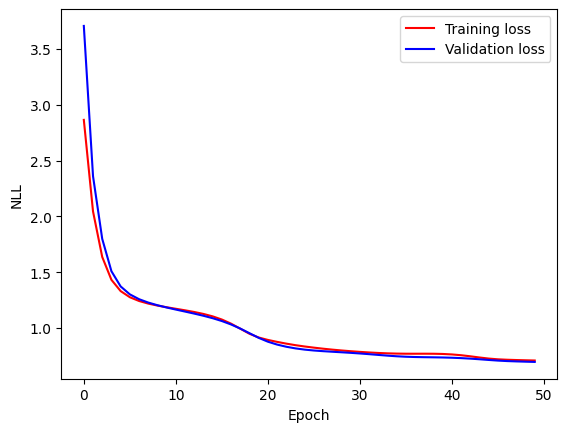

In [25]:
#-------------------------------------------------------------------------
def execute_part14(hidden_layer_size, vocab_size, word_to_idx, idx_to_word, training_set, validation_set, test_set):
    print('PART 14')
    train_LSTM_result = train_LSTM(
        hidden_layer_size   = hidden_layer_size,
        vocab_size          = vocab_size,
        word_to_idx         = word_to_idx,
        training_set        = training_set,
        validation_set      = validation_set,
    )
    make_prediction(
        hidden_layer_size   = hidden_layer_size,
        vocab_size          = vocab_size,
        idx_to_word         = idx_to_word,
        word_to_idx         = word_to_idx,
        params              = train_LSTM_result['params'],
        test_set            = test_set
    )
    plot_graph(
        training_loss       = train_LSTM_result['training_loss'],
        validation_loss     = train_LSTM_result['validation_loss']
    )
#-------------------------------------------------------------------------
execute_part14(
    hidden_layer_size   = part11_result['hidden_layer_size'],
    vocab_size          = part11_result['vocab_size'],
    word_to_idx         = part11_result['word_to_idx'],
    idx_to_word         = part11_result['idx_to_word'],
    training_set        = part11_result['training_set'],
    validation_set      = part11_result['validation_set'],
    test_set            = part11_result['test_set']
)

## Exercise:

Run the training loop above. What do you notice about the loss and number of epochs compared to the vanilla RNN from earlier?

## PyTorch implementation of the LSTM

Now that we know how the LSTM cell works, let's see how easy it is to use in PyTorch!

Definition of our LSTM network. We define a LSTM layer using the [nn.LSTM](https://pytorch.org/docs/stable/nn.html#lstm) class. The LSTM layer takes as argument the size of the input and the size of the hidden state like in our numpy implementation.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from torch.utils import data
import matplotlib.pyplot as plt

np.random.seed(42)

In [10]:
#-------------------------------------------------------------------------
class Net(nn.Module):
    #-------------------------------------------------------------------------
    def __init__(self, vocab_size, hidden_layer_size = 50, num_layers = 1):
        super(Net, self).__init__()

        # Recurrent layer
        self.lstm = nn.LSTM(
            input_size     = vocab_size, # typically 4 in our example
            hidden_size    = hidden_layer_size, # hidden layer size (LSTM units in this layer)
            num_layers     = num_layers,
            bidirectional  = False
        )
        
        # Output layer
        self.l_out = nn.Linear(
            in_features     = hidden_layer_size, # we are going to output a size 50 vector from the LSTM layer, that has 50 units
            out_features    = vocab_size,
            bias            = False
        )
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x) # x = input, h = hidden state, c = cell state
        
        # Flatten output for feed-forward layer
        #   -1: tells PyTorch to infer the size of this dimension based on the other dimensions and the total number of elements in the tensor. 
        #     Essentially, it allows PyTorch to automatically calculate the appropriate size for this dimension
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x
    #-------------------------------------------------------------------------
#-------------------------------------------------------------------------

### Training loop

It's time for us to train our network. In the section below, you will get to put your deep learning skills to use and create your own training loop. You may want to consult previous exercises if you cannot recall how to define the training loop.

In [11]:
#-------------------------------------------------------------------------
def generate_dataset(num_sequences=100):
    """
    Generates a number of sequences as our dataset.
    Args:
     `num_sequences`: the number of sequences to be generated.
    Returns a list of sequences.
    """

    samples = []
    
    for _ in range(num_sequences):  
        num_tokens = np.random.randint(1, 10) # pick a number of tokens to be generated
        # generate an equal number of 'a's and 'b's, followed by an 'EOS' token, e.g.: ['a', 'a', 'a', 'b', 'b', 'b', 'EOS']
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def sequences_to_dicts(sequences):
    """
    Creates word_to_idx and idx_to_word dictionaries for a list of sequences.
    Args:
        `sequences`: a list of sequences
    """
    
    # A bit of Python-magic to flatten a nested list 'list_param'
    flatten = lambda list_param: [
        item 
        for sublist in list_param #loop over the elements of list_param creating a sublist
        for item in sublist #loop over the elements of sublist creating an item
    ]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int) #defaultdict is a dictionary that returns a default value if the key is not found, here the default value is 0
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency in descending order
    # word_count.items() returns a list of (word, count) pairs. 'l' is a tuple (word, count). Then we sort the list of tuples by the count '-l[1]'
    # this would be better as: word_count_desc = sorted(list(word_count.items()), key=lambda tuple_item: tuple_item[1], reverse=True)
    word_count_desc = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count_desc]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    # word_to_idx = defaultdict(lambda: num_words) #probably should be vocab_size
    word_to_idx = defaultdict(lambda: vocab_size)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs # x
        self.targets = targets # y

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        x = self.inputs[index]
        y = self.targets[index]

        return x, y
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def get_inputs_targets_from_sequences(sequences):
    # Define empty lists
    inputs, targets = [], []
    
    # Append inputs and targets such that both lists contain L-1 words of a sentence of length L
    # but targets are shifted right by one so that we can predict the next word
    # example: 'The quick brown fox jumps'
    #    Inputs:  ["The", "quick", "brown", "fox"]
    #    Targets: ["quick", "brown", "fox", "jumps"]
    # The idea is to predict the next word based on the input words, so the model learns to predict 
    # "quick" given "The", "brown" given "quick", and so on.
    for sequence in sequences:
        inputs.append(sequence[:-1]) # take everything except the last word -> ["The", "quick", "brown", "fox"]
        targets.append(sequence[1:]) # take everything except the first word -> ["quick", "brown", "fox", "jumps"]
        
    return inputs, targets
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int( len(sequences)*p_train ) #typically 80% of the data
    num_validation = int( len(sequences)*p_val )     #typically 10% of the data
    num_test = int( len(sequences)*p_test )   #typically 10% of the data

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_validation = sequences[num_train:num_train+num_validation]
    sequences_test = sequences[-num_test:]

    # In the next step we split this into inputs and targets. So far we have sequences for: 
    #   Training, Validation, and Test. After that we will have:
    #   Training (Inputs, Targets), Validation (Inputs, Targets), and Test (Inputs, Targets)

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_validation, targets_validation = get_inputs_targets_from_sequences(sequences_validation)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_validation, targets_validation)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------    
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
       
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """

    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------    
def one_hot_encode_sequence(sequence, vocab_size, word_to_idx):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
        
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """

    # Encode each word in the sentence. From each word in a sentence, we send the index of the word and vocab_size
    #  we expect to receive back the one-hot encoding of the word, something like [0,0,0,1,0,0,0,...]
    encoding = np.array(
            [   
                one_hot_encode(word_to_idx[word], vocab_size) 
                for word in sequence
            ]
        )

    # Reshape encoding to (len_num words, len_vocab size, 1)
    encoding = encoding.reshape( encoding.shape[0], encoding.shape[1], 1 )
    
    return encoding
#-------------------------------------------------------------------------

In [12]:
#-------------------------------------------------------------------------
def execute_part11_I():
    print('Part 11 - I')
    sequences = generate_dataset()
    print('A single sample from the generated dataset:')
    print(sequences[0])
    return {
        'sequences': sequences
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part11_II(sequences):
    print('Part 11 - II')
    word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)
    print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
    print('The index of \'b\' is', word_to_idx['b'])
    print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

    print(f'vocab_size: {vocab_size}')
    for i in range(vocab_size):
        print(f'{i}: {idx_to_word[i]}')      
    return {
        'word_to_idx': word_to_idx,
        'idx_to_word': idx_to_word,
        'num_sequences': num_sequences,
        'vocab_size': vocab_size
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part11_III(sequences):
    print('Part 11 - III')
    training_set, validation_set, test_set = create_datasets(sequences = sequences, dataset_class = Dataset)
    return {
        'training_set': training_set,
        'validation_set': validation_set,
        'test_set': test_set
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part11(hidden_layer_size = 50):
    print('PART 11')
    print('----------------')
    part11_I_result = execute_part11_I()
    print('----------------')
    part11_II_result = execute_part11_II(part11_I_result['sequences'])
    print('----------------')
    part11_III_result = execute_part11_III(part11_I_result['sequences'])
    print('----------------')
    
    vocab_size = part11_II_result['vocab_size']
    # z_size = hidden_layer_size + vocab_size # typically: 50 + 4 = 54
    # params = init_lstm(hidden_layer_size=hidden_layer_size, vocab_size=vocab_size, z_size=z_size)

    return {
        'sequences'     : part11_I_result['sequences'],
        'vocab_size'    : vocab_size,
        'word_to_idx'   : part11_II_result['word_to_idx'],
        'idx_to_word'   : part11_II_result['idx_to_word'],
        'num_sequences' : part11_II_result['num_sequences'],
        'hidden_layer_size': hidden_layer_size,
        # 'params'        : params,
        'training_set'  : part11_III_result['training_set'],
        'validation_set': part11_III_result['validation_set'],
        'test_set'      : part11_III_result['test_set']
    }
#-------------------------------------------------------------------------

In [13]:
#-------------------------------------------------------------------------
def train_lstm(validation_set, training_set, word_to_idx, vocab_size):
    # Hyper-parameters
    num_epochs = 50

    # Initialize a new network
    net = Net(vocab_size = vocab_size)

    # Define a loss function and optimizer for this problem
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

    # Track loss
    training_loss, validation_loss = [], []

    #-------------------------------------------------
    # For each epoch
    for i in range(num_epochs):
        
        # Track loss
        epoch_training_loss = 0
        epoch_validation_loss = 0
        
        #----------
        # net.eval() is a method call in PyTorch that sets the neural network model net to evaluation mode. 
        #   This is particularly important when you are transitioning from the training phase to the 
        #   evaluation or inference phase of your model's lifecycle. During training, certain layers 
        #   like Dropout and BatchNorm behave differently to facilitate learning. For instance, Dropout 
        #   randomly zeroes some of the elements of the input tensor with a given probability during 
        #   training to prevent overfitting. BatchNorm normalizes the output of a previous activation 
        #   layer by subtracting the batch mean and dividing by the batch standard deviation
        #
        # When you call net.eval(), it changes the behavior of these layers to be appropriate for 
        #   evaluation. Specifically, Dropout layers will no longer drop any units, and BatchNorm layers 
        #   will use the learned running statistics instead of batch statistics. This ensures that the 
        #   model's predictions are deterministic and consistent, which is crucial for evaluating the 
        #   model's performance on a validation set or making predictions on new data.       
        net.eval()
        #----------
            
        #-------------------------------------------------
        # For each sentence in validation set
        for inputs, targets in validation_set:
            
            # One-hot encode input and target sequence
            inputs_one_hot = one_hot_encode_sequence(sequence = inputs, vocab_size=vocab_size, word_to_idx=word_to_idx)
            
            
            # consider a target sequence: [a, a, b, b, b, EOS], and the word_to_idx represents 
            #   a - 0, b - 1, EOS - 2, UNK - 3. That means that the targets_idx will be [0, 0, 1, 1, 1, 2]
            targets_idx = [ word_to_idx[word] for word in targets ]

            
            #----------------
            # Convert input to tensor
            #  lets break this down: the first input las a length of 6, our vocabulary has a length of 4
            #  therefore input is len 6 -> ['a', 'a', 'a', 'b', 'b', 'b'], and input_one_hot is len 6x4x1 ->
            #     [ [ [1.], [0.], [0.], [0.] ], ... ]
            #  but then inputs_one_hot will be wrapped in a tensor object -> torch.Size([6, 4, 1])
            inputs_one_hot = torch.Tensor(inputs_one_hot)

            #-----------------
            # inputs_one_hot is being rearranged such that the first dimension (index 0) remains in place, 
            #   the second dimension (index 1) is moved to the third position, and the third dimension 
            #   (index 2) is moved to the second position. It was [6,4,1] and it will become [6,1,4]
            #
            # To break it down further, if inputs_one_hot originally had dimensions 
            #   [batch_size, seq_len, num_features], after the permutation, it would have dimensions 
            #   [batch_size, num_features, seq_len]
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1)



            # Convert target to tensor
            targets_idx = torch.LongTensor(targets_idx) #just wraps the list in a tensor object

            
            # Forward pass
            #  considering a target sentence of length 6 and vocab len 4 the shape will be: [6, 4]
            outputs = net.forward(inputs_one_hot) 
            
            # Compute loss
            loss = criterion(outputs, targets_idx)
            
            # Update loss
            epoch_validation_loss += loss.detach().numpy()
        #-------------------------------------------------

        # When a model is in training mode, certain layers like Dropout and BatchNorm behave differently 
        #  compared to when the model is in evaluation mode. Specifically, Dropout layers will randomly 
        #  zero some of the elements of the input tensor with a given probability, which helps prevent 
        #  overfitting. BatchNorm layers will use the statistics of the current batch rather than the 
        #  running statistics accumulated during training
        #
        # By calling net.train(), you are preparing the model net to be trained, enabling the specific 
        #   behaviors of certain layers that are necessary for effective training. This step is typically 
        #   followed by the actual training loop, where the model parameters are updated based on the 
        #   loss computed from the training data
        net.train()
        
        #-------------------------------------------------
        # For each sentence in training set
        for inputs, targets in training_set:
            
            # One-hot encode input and target sequence
            inputs_one_hot = one_hot_encode_sequence(sequence = inputs, vocab_size = vocab_size, word_to_idx = word_to_idx)
            targets_idx = [word_to_idx[word] for word in targets] #see explanation above
            
            # Convert input to tensor
            inputs_one_hot = torch.Tensor(inputs_one_hot)
            inputs_one_hot = inputs_one_hot.permute(0, 2, 1) #see explanation above
            
            # Convert target to tensor
            targets_idx = torch.LongTensor(targets_idx)
            
            # Forward pass
            outputs = net.forward(inputs_one_hot)
            
            # Compute loss
            loss = criterion(outputs, targets_idx)
            
            # Backward pass
            #  PyTorch accumulates gradients by default. This means that if you don't reset the gradients, 
            #    they will be summed up across multiple backward passes, leading to incorrect updates
            optimizer.zero_grad() 
            loss.backward() #the actual backpropagation step

            # by calling optimizer.step(), you trigger this entire process, leading to the adjustment 
            #   of the model's parameters based on the computed gradients
            optimizer.step()
            
            # Update loss
            epoch_training_loss += loss.detach().numpy()
        #-------------------------------------------------

        # Save loss for plot
        training_loss.append(epoch_training_loss/len(training_set))
        validation_loss.append(epoch_validation_loss/len(validation_set))

        # Print loss every 5 epochs
        if i % 5 == 0:
            print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
    #-------------------------------------------------

    return {
        'net': net,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }
#-------------------------------------------------------------------------

In [14]:
#-------------------------------------------------------------------------
def make_prediction(net, test_set, word_to_idx, idx_to_word, vocab_size):
            
    # Get first sentence in test set
    inputs, targets = test_set[1]

    # One-hot encode input and target sequence
    inputs_one_hot = one_hot_encode_sequence(sequence = inputs, vocab_size = vocab_size, word_to_idx=word_to_idx)
    targets_idx = [word_to_idx[word] for word in targets]

    # Convert input to tensor
    inputs_one_hot = torch.Tensor(inputs_one_hot)
    inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

    # Convert target to tensor
    targets_idx = torch.LongTensor(targets_idx)

    # Forward pass
    outputs = net.forward(inputs_one_hot).data.numpy()

    print('\nInput sequence:')
    print(inputs)

    print('\nTarget sequence:')
    print(targets)

    print('\nPredicted sequence:')
    print([idx_to_word[np.argmax(output)] for output in outputs])
#-------------------------------------------------------------------------

In [15]:
#-------------------------------------------------------------------------
def plot_graph(training_loss, validation_loss):
    # Plot training and validation loss
    epoch = np.arange(len(training_loss))
    plt.figure()
    plt.plot(epoch, training_loss, 'r', label='Training loss',)
    plt.plot(epoch, validation_loss, 'b', label='Validation loss')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('NLL')
    plt.show()    
#-------------------------------------------------------------------------

PART 11
----------------
Part 11 - I
A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
----------------
Part 11 - II
We have 100 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'
vocab_size: 4
0: a
1: b
2: EOS
3: UNK
----------------
Part 11 - III
----------------
Epoch 0, training loss: 1.3325377151370048, validation loss: 1.394657063484192
Epoch 5, training loss: 0.7525688607245684, validation loss: 0.8108136773109436
Epoch 10, training loss: 0.5548159960657358, validation loss: 0.6026391595602035
Epoch 15, training loss: 0.46124364286661146, validation loss: 0.49853705167770385
Epoch 20, training loss: 0.40653422977775333, validation loss: 0.4367683157324791
Epoch 25, training loss: 0.3750861071050167, validation loss: 0.39974591732025144
Epoch 30, training loss: 0.35479279458522794, validation loss: 0.3761331379413605
Epoch 35, training

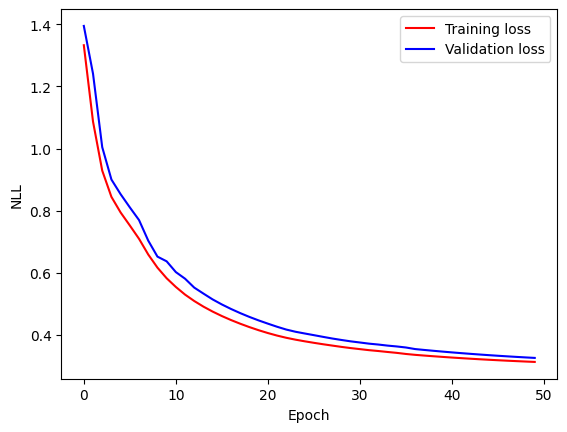

In [16]:
#-------------------------------------------------------------------------
def execute_part16():
    part11_result = execute_part11()
    train_lstm_result   = train_lstm(
        validation_set  = part11_result['validation_set'],
        training_set    = part11_result['training_set'],
        word_to_idx     = part11_result['word_to_idx'],
        vocab_size      = part11_result['vocab_size']
    )

    # make_prediction(
    make_prediction(
        net         = train_lstm_result['net'],
        test_set    = part11_result['test_set'], 
        word_to_idx = part11_result['word_to_idx'],
        idx_to_word = part11_result['idx_to_word'],
        vocab_size  = part11_result['vocab_size']
    )
    plot_graph(
        training_loss   = train_lstm_result['training_loss'], 
        validation_loss = train_lstm_result['validation_loss']
    )
#-------------------------------------------------------------------------
execute_part16()

## Exercise:

Finish the training loop above and run the training. Compare your loss to the numpy implementation. Are they similar?

Try to play around with the hyper-parameters and hidden dimensions. How low of a negative log-likelihood can you achieve?

## Exercise (optional)

Aside from the LSTM cell, various other RNN cells exist. The gated recurrent unit (GRU) is a variation of the LSTM cell that uses less parameters. Try to look it up in the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#gru) and switch out the LSTM cell in the code above. What do you notice in terms of performance and convergence speed?

# Where to go from here?

In this notebook you have learned how to use embeddings, recurrent neural networks and the LSTM cell in particular.

As we have already seen, RNNs are excellent for sequential data such as language. But what do we do if we're modelling data with strong dependency in both directions? Like in many things deep learning, we can build powerful models by stacking layers on top of each other: *bi-directional* RNNs consist of two LSTM cells, one for each direction. A sequence is first fed into the forward LSTM cell and the reversed sequence is then used as input to the backward LSTM cell together with the last hidden state from the forward LSTM cell. Follow [this link](https://pdfs.semanticscholar.org/4b80/89bc9b49f84de43acc2eb8900035f7d492b2.pdf) for the original paper from 1997(!).

For even deeper representations, multiple layers of both uni-directional and bi-directional RNNs can be stacked ontop of each other, just like feed-forward and convolutional layers! For more information on this, check out the [LSTM PyTorch documentation](https://pytorch.org/docs/stable/nn.html#lstm).